In [14]:
from pathlib import Path
from typing import Any
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_acc, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc
from evaluation import calc_angle_err, print_err_status, save_err_csv
from evaluation import plot_err_from_csv, plot_quasi_static_diagnostic, plot_err_colored_by_weight
from evaluation import save_estimated_vec3_csv, evaluate_estimated_vec3_autosign
from resample import find_stable_start_idx, cut_sample
from autotune import auto_setup_imu_frame, quasi_static_detector, suggest_gate_sigma
from autotune import choose_tau_from_quasi_static, choose_best_by_sigma_scale
from Tee import Tee

SIGMA_FLOOR: float = 1e-3
EPS: float = 1e-9

In [15]:
sample_1: str = "data01_21:08_oct_07_2025_5min"
sample_2: str = "data02_21:23_oct_07_2025_9min"
sample_3: str = "data03_21:41_oct_07_2025_13min"
sample_4: str = "data04_18:52_oct_08_2025_96min"

sample: str = sample_1

root: Path = Path.cwd().parent
run_dir: Path = root / "data" / sample

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"

for p in [ori_path, gyro_path, acc_path, grav_path, acc_lin_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

out_dir: Path = root / "output" / sample
out_dir.mkdir(parents=True, exist_ok=True)

#path_log: Path = out_dir / "02_exp2_log.txt"
path_log: Path = out_dir / "02_exp2_log_.txt"
path_err_1: Path = out_dir / "02_exp2-1_angle_err.csv"
path_err_2: Path = out_dir / "02_exp2-2_angle_err.csv"
path_err_3: Path = out_dir / "02_exp2-3_angle_err.csv"
path_plot_quasi_static: Path = out_dir / "02_exp2_quasi_static.png"
path_plot: Path = out_dir / "02_exp2_plot.png"
path_plot_weight: Path = out_dir / "02_exp2_plot_weight.png"


#for p in [path_log, path_err_1, path_err_2, path_err_3,
#          path_plot_quasi_static, path_plot, path_plot_weight]:
#        if p.is_file():
#                p.unlink()

In [16]:
with Tee(path_log):
        t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

        q_ref_interp = load_ref(ori_path, t_new)
        q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

        idx_cut: int = find_stable_start_idx(dt, w_avg_gyro, q_ref_interp,
                                             sample_window=1000, threshold=0.5, sample_hz=100,
                                             consecutive=3, min_cut_second=10, max_cut_second=30)
        t_cut: int = idx_cut / 100
        a_src_interp = load_acc(acc_path, t_new)
        dt, t_new, w_avg_gyro, q_ref_interp, a_src_interp = cut_sample(idx_cut,
                                                                       [dt, t_new, w_avg_gyro, q_ref_interp, a_src_interp])



[START] 2026-02-28 02:35:21.339

[INFO] Stabilization detected too early (< min_cut), applying min_cut=10s policy

[END] 2026-02-28 02:35:21.861




In [17]:
with Tee(path_log):
        q0: Quat = q_ref_interp[0].copy()
        g0: float = 9.80665
        a_src_interp, g_world_unit = auto_setup_imu_frame(q_ref_interp, w_avg_gyro, dt,
                                                          g0, a_src_interp)
        print("")

        best_quasi_static = quasi_static_detector(w_avg_gyro, a_src_interp, dt, g0,
                                                  w_thr=4, a_thr=4,
                                                  min_duration_s=0.5, smooth_win=5)
        print("")

        gyro_gate_sigma, acc_gate_sigma = suggest_gate_sigma(w_avg_gyro, a_src_interp, g0,
                                                             p_gyro=90, p_acc=90, sigma_floor=SIGMA_FLOOR,
                                                             best_quasi_static=best_quasi_static)



[START] 2026-02-28 02:35:21.881

Detected accel unit in [m/s²]
Selected g_world_unit: [ 0  0 -1]

Best quasi static(start, end, length):  (2523, 3540, 1017)

Suggested gyro_sigma:  0.44791971689543864
Suggested acc_sigma:  2.908568806018301

[END] 2026-02-28 02:35:23.041




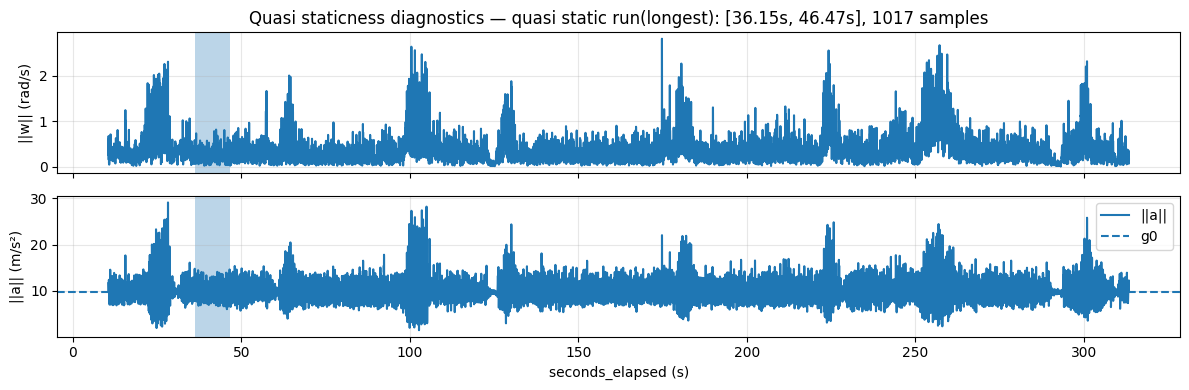

In [18]:
plot_quasi_static_diagnostic(t_new, w_avg_gyro, a_src_interp, g0,
                             best_quasi_static,
                             path_plot_quasi_static)

In [19]:
def runner_exp2(*,
               K: float,
               acc_gate_sigma: float,
               gyro_gate_sigma = np.inf,
               mag_gate_sigma = np.inf,
               **kwargs: Any):
        q_est, g_body_est, a_lin_est, weight_acc, weight_gyro = integrate_gyro_acc(
                                                        q0, w_avg_gyro, dt,
                                                        K, g0, g_world_unit,
                                                        acc_gate_sigma, gyro_gate_sigma, a_src_interp)
        return q_est, (g_body_est, a_lin_est, weight_acc, weight_gyro)

In [20]:
## exp1: without any gating

with Tee(path_log):
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(
                                                        dt=dt, runner_func=runner_exp2,      
                                                        best_quasi_static=best_quasi_static,
                                                        tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3),
                                                        runner_kwargs={"acc_gate_sigma": np.inf,
                                                                       "gyro_gate_sigma": np.inf})
        print("\nchosen tau: ", best_tau, ", K: ", K, "\n")

        q_est_1, extra = runner_exp2(K=K, acc_gate_sigma=np.inf, gyro_gate_sigma=np.inf)
        g_body_est_1, a_lin_est_1, weight_acc_1, weight_gyro_1 = extra

        print("[choosen value]")
        print("tau=", best_tau, "K=", K)
        print(f"acc_gate_sigma=inf")
        print(f"gyro_gate_sigma=inf\n")

        angle_err_1: ScalarBatch = calc_angle_err(q_est_1, q_ref_interp)
        print_err_status("[exp 2-1] Gyro+Acc", angle_err_1)



[START] 2026-02-28 02:35:24.096

tau=0.2 , K=0.049993896484394895 , quasi_static_score_mean_angle(rad)=0.0453472834175563
tau=0.3 , K=0.03332926432292993 , quasi_static_score_mean_angle(rad)=0.03706716993476759
tau=0.5 , K=0.019997558593757958 , quasi_static_score_mean_angle(rad)=0.03127072144959298
tau=0.7 , K=0.014283970424112828 , quasi_static_score_mean_angle(rad)=0.030268340351771967
tau=1.0 , K=0.009998779296878979 , quasi_static_score_mean_angle(rad)=0.03065495906772654
tau=1.5 , K=0.006665852864585986 , quasi_static_score_mean_angle(rad)=0.031313599345832714
tau=2.0 , K=0.0049993896484394895 , quasi_static_score_mean_angle(rad)=0.031135931826132664
tau=3.0 , K=0.003332926432292993 , quasi_static_score_mean_angle(rad)=0.029962505648007294

chosen tau:  3.0 , K:  0.003332926432292993 

[choosen value]
tau= 3.0 K= 0.003332926432292993
acc_gate_sigma=inf
gyro_gate_sigma=inf

[exp 2-1] Gyro+Acc angle error in rad — min/max/mean/p90
0.0028253656890090757 1.4041137225284805 0.341414

In [21]:
# exp 2-2: Gyro+Acc+Gating(Acc)

with Tee(path_log):
        print("[choosing tau, K]")
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(
                                                        dt=dt, runner_func=runner_exp2,      
                                                        best_quasi_static=best_quasi_static,
                                                        tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3),
                                                        runner_kwargs={"acc_gate_sigma": acc_gate_sigma,
                                                                       "gyro_gate_sigma": np.inf})
        print("\nchosen tau: ", best_tau, ", K: ", K, "\n")

        print("[choosing acc_gate_sigma]")
        best_acc = choose_best_by_sigma_scale(scales=[0.01, 1, 10, np.inf],
                                              K=K, sigma_base=acc_gate_sigma, q_ref=q_ref_interp,
                                              runner_func=runner_exp2,
                                              sigma_kw="acc_gate_sigma",
                                              fixed_kwargs={"gyro_gate_sigma": np.inf})
        print(f"\nchosen sa={best_acc.scale}, ", f"acc_gate_sigma={best_acc.sigma:.7f}\n")

        best_acc_scale, best_acc_sigma = best_acc.scale, best_acc.sigma
        angle_err_2 = best_acc.angle_err
        g_body_est_2, a_lin_est_2, weight_acc_2, weight_gyro_2 = best_acc.extra

        print("[choosen value]")
        print("tau=", best_tau, ", K=", K)
        print(f"sa={best_acc_scale}, ", f"acc_gate_sigma={best_acc_sigma:.7f}")
        print(f"gyro_gate_sigma=inf\n")

        print_err_status("[exp 2-2] Gyro+Acc+Gating(Acc)", angle_err_2)



[START] 2026-02-28 02:36:18.010

[choosing tau, K]
tau=0.2 , K=0.049993896484394895 , quasi_static_score_mean_angle(rad)=0.0437275322370169
tau=0.3 , K=0.03332926432292993 , quasi_static_score_mean_angle(rad)=0.03660690253873771
tau=0.5 , K=0.019997558593757958 , quasi_static_score_mean_angle(rad)=0.03234543260647222
tau=0.7 , K=0.014283970424112828 , quasi_static_score_mean_angle(rad)=0.03201273748875968
tau=1.0 , K=0.009998779296878979 , quasi_static_score_mean_angle(rad)=0.0326082798955483
tau=1.5 , K=0.006665852864585986 , quasi_static_score_mean_angle(rad)=0.03285388837167838
tau=2.0 , K=0.0049993896484394895 , quasi_static_score_mean_angle(rad)=0.03225662424307239
tau=3.0 , K=0.003332926432292993 , quasi_static_score_mean_angle(rad)=0.030734069360916487

chosen tau:  3.0 , K:  0.003332926432292993 

[choosing acc_gate_sigma]
scale=0.01 , acc_gate_sigma=0.0290857 , mean_err(rad)=0.3636687
scale=1 , acc_gate_sigma=2.9085688 , mean_err(rad)=0.3401973
scale=10 , acc_gate_sigma=29.0

In [22]:
# exp 2-3: Gyro+Acc+Gating(Gyro/Acc)

with Tee(path_log):
        print("[choosing tau, K]")
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(
                                                        dt=dt, runner_func=runner_exp2,      
                                                        best_quasi_static=best_quasi_static,
                                                        tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3),
                                                        runner_kwargs={"acc_gate_sigma": acc_gate_sigma,
                                                                       "gyro_gate_sigma": gyro_gate_sigma})
        print("\nchosen tau: ", best_tau, ", K: ", K, "\n")

        print("[choosing acc_gate_sigma]")
        best_acc = choose_best_by_sigma_scale(scales=[0.01, 1, 10, np.inf],
                                          K=K, sigma_base=acc_gate_sigma, q_ref=q_ref_interp,
                                          runner_func=runner_exp2,
                                          sigma_kw="acc_gate_sigma",
                                          fixed_kwargs={"gyro_gate_sigma": np.inf})
        print(f"\nchosen sa={best_acc.scale}, ", f"acc_gate_sigma={best_acc.sigma:.7f}\n")
        best_acc_scale, best_acc_sigma = best_acc.scale, best_acc.sigma
        
        print("[choosing gyro_gate_sigma]")
        best_gyro = choose_best_by_sigma_scale(scales=[0.01, 1, 10, np.inf],
                                          K=K, sigma_base=gyro_gate_sigma, q_ref=q_ref_interp,
                                          runner_func=runner_exp2,
                                          sigma_kw="gyro_gate_sigma",
                                          fixed_kwargs={"acc_gate_sigma": best_acc_sigma})
        print(f"\nchosen sg={best_gyro.scale}, ", f"gyro_gate_sigma={best_gyro.sigma:.7f}\n")

        best_gyro_scale, best_gyro_sigma = best_gyro.scale, best_gyro.sigma
        angle_err_3 = best_gyro.angle_err
        g_body_est_3, a_lin_est_3, weight_acc_3, weight_gyro_3 = best_gyro.extra

        print("[choosen value]")
        print("tau=", best_tau, ", K=", K)
        print(f"sa={best_acc_scale}, ", f"acc_gate_sigma={best_acc_sigma:.7f}")
        print(f"sg={best_gyro_scale}, ", f"gyro_gate_sigma={best_gyro_sigma:.7f}\n")

        print_err_status("[exp 2-3] Gyro+Acc+Gating(Gyro/Acc)", angle_err_3)



[START] 2026-02-28 02:37:29.868

[choosing tau, K]
tau=0.2 , K=0.049993896484394895 , quasi_static_score_mean_angle(rad)=0.03943992605456148
tau=0.3 , K=0.03332926432292993 , quasi_static_score_mean_angle(rad)=0.033983562129765534
tau=0.5 , K=0.019997558593757958 , quasi_static_score_mean_angle(rad)=0.03155513160068821
tau=0.7 , K=0.014283970424112828 , quasi_static_score_mean_angle(rad)=0.03164593770576931
tau=1.0 , K=0.009998779296878979 , quasi_static_score_mean_angle(rad)=0.03185542227322495
tau=1.5 , K=0.006665852864585986 , quasi_static_score_mean_angle(rad)=0.031138085296789686
tau=2.0 , K=0.0049993896484394895 , quasi_static_score_mean_angle(rad)=0.03003151214641173
tau=3.0 , K=0.003332926432292993 , quasi_static_score_mean_angle(rad)=0.028151859762228833

chosen tau:  3.0 , K:  0.003332926432292993 

[choosing acc_gate_sigma]
scale=0.01 , acc_gate_sigma=0.0290857 , mean_err(rad)=0.3636687
scale=1 , acc_gate_sigma=2.9085688 , mean_err(rad)=0.3401973
scale=10 , acc_gate_sigma=

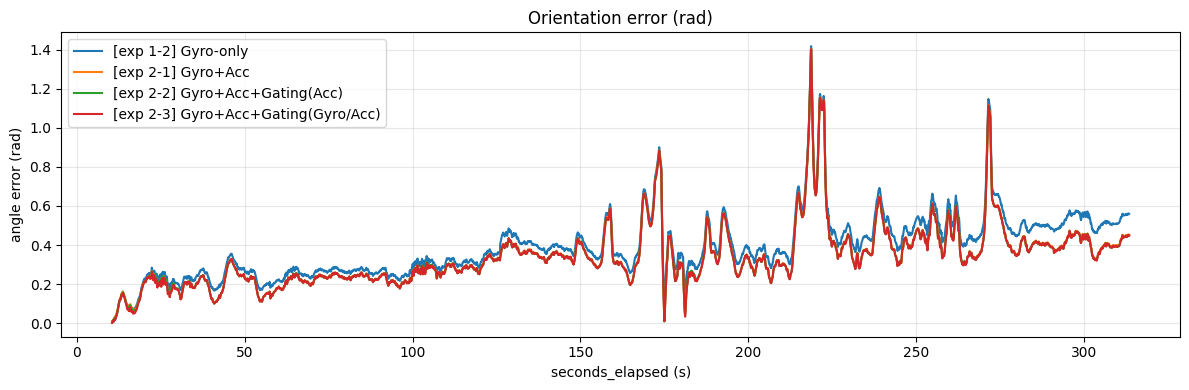

In [23]:
save_err_csv(path_err_1, t_new, angle_err_1)
save_err_csv(path_err_2, t_new, angle_err_2)
save_err_csv(path_err_3, t_new, angle_err_3)

path_err_exp1_2 = out_dir / "01_exp1-2_angle_err.csv"

plot_err_from_csv([
        ("[exp 1-2] Gyro-only", path_err_exp1_2),
        ("[exp 2-1] Gyro+Acc", path_err_1),
        ("[exp 2-2] Gyro+Acc+Gating(Acc)", path_err_2),
        ("[exp 2-3] Gyro+Acc+Gating(Gyro/Acc)", path_err_3)],
                  path_plot)

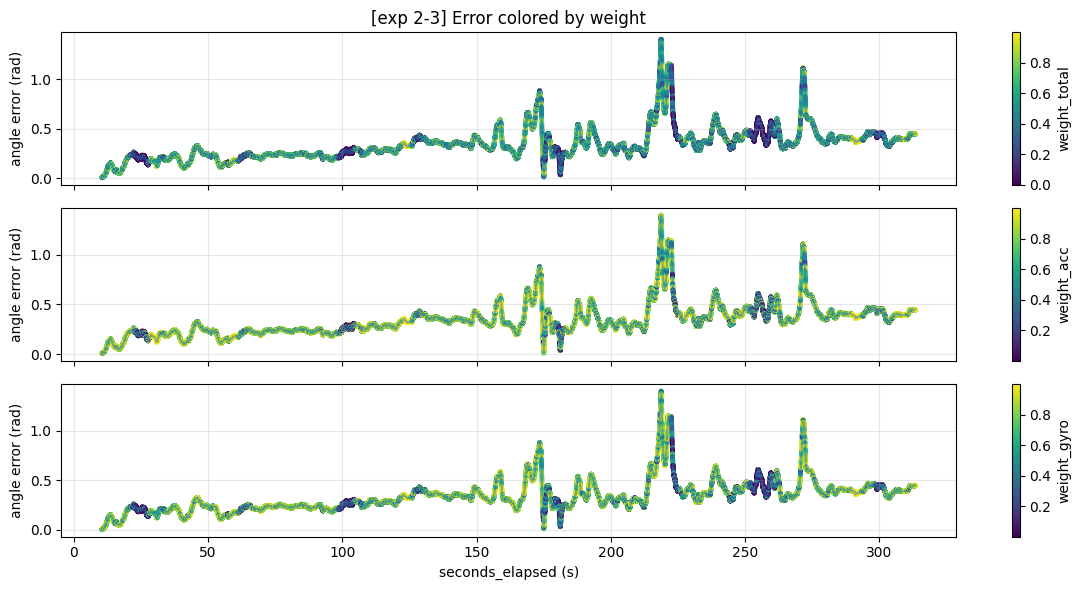

In [24]:
plot_err_colored_by_weight(t_new, angle_err_3,
                           weight_acc_3, weight_gyro_3, weight_acc_3 * weight_gyro_3,
                           path_plot_weight)

In [25]:
#est_dir: Path = root / "estimate"
#est_dir.mkdir(parents=True, exist_ok=True)

#print("Gravity:")
#g_ref_interp = load_grav_ref(grav_path, t_new)
#g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
#print("")

#print("Linear Acc:")
#a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
#a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
#print("")

#save_estimated_vec3_csv(est_dir / "03_gravity_estimated.csv", t_new, g_est_sign_fixed)
#save_estimated_vec3_csv(est_dir / "03_linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

#print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

In [26]:
#import numpy as np

#def unit(v):
#    n = np.linalg.norm(v, axis=1, keepdims=True)
#    return v / np.maximum(n, 1e-12)

#def gravity_direction_angle_err(g_est: np.ndarray, g_ref: np.ndarray):
#    ge = unit(g_est)
#    gr = unit(g_ref)
#    c = np.sum(ge * gr, axis=1)
#    c = np.clip(c, -1.0, 1.0)
#    ang = np.arccos(c)  # rad
#    print("gravity dir angle err (rad): min/max/mean",
#          float(ang.min()), float(ang.max()), float(ang.mean()))
#    print("gravity dir angle err (deg): min/max/mean",
#          float(np.rad2deg(ang.min())), float(np.rad2deg(ang.max())), float(np.rad2deg(ang.mean())))
#    return ang

#def accel_gravity_alignment(a_src: np.ndarray, g_est: np.ndarray, g0: float, thr: float = 0.3):
#    a_norm = np.linalg.norm(a_src, axis=1)
#    mask = np.abs(a_norm - g0) < thr

#    au = unit(a_src)
#    gu = unit(g_est)
#    dot = np.sum(au * gu, axis=1)  # 부호는 플랫폼 정의에 따라 +/-1이 목표

#    d = dot[mask]
#    print(f"stationary mask count: {int(mask.sum())}/{len(mask)}")
#    print("dot(a_unit, g_unit) on stationary: mean/min/max",
#          float(np.mean(d)), float(np.min(d)), float(np.max(d)))
#    return dot, mask

#gravity_direction_angle_err(g_est_sign_fixed, g_ref_interp)
#print("=============")
#accel_gravity_alignment(a_src_interp, g_est_sign_fixed, g0)
#print("=============")